## Data Analysis

### Import Modules

In [1]:
#Data Cleaning
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.stats import f_oneway

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sn
import random

# Data Extraction
import requests
import json

### Load Data from CSV

In [2]:
iso_cleaned_df = pd.read_csv('./Resources/isoDataFinal.csv')
vaccination_df = pd.read_csv('./Resources/iso_code.csv')

In [3]:
iso_cleaned_df.head(10)

,iso_code,Country,GDP,Total_Pop,Pop_Den,health_exp,Lat_avg,Lng_avg,total_vaccinations,people_fully_vaccinated_per_hundred
0,ALB,Albania,1.514702e+10,2866376.0,104.612263,44.657787,41.0000,20.0000,400064.0,0.02
1,AND,Andorra,3.218316e+09,77006.0,163.842553,32.065220,42.5000,1.6000,26414.0,6.06
2,ARE,United Arab Emirates,4.222150e+11,9630959.0,135.609110,48.421539,24.0000,54.0000,10336214.0,38.79
3,ARG,Argentina,5.176267e+11,44494502.0,16.258510,38.290127,-34.0000,-64.0000,7386650.0,1.95
4,AUT,Austria,4.550949e+11,8840521.0,107.131859,26.914829,47.3333,13.3333,2863389.0,8.73
5,AZE,Azerbaijan,4.711294e+10,9939771.0,120.257592,72.804810,40.5000,47.5000,1440243.0,4.87
6,BEL,Belgium,5.437344e+11,11427054.0,377.379590,24.215460,50.8333,4.0000,3563371.0,6.60
7,BGD,Bangladesh,2.740391e+11,161356039.0,1239.579312,76.501839,24.0000,90.0000,7954176.0,1.31
8,BGR,Bulgaria,6.623016e+10,7025037.0,64.711100,42.363476,43.0000,25.0000,750899.0,2.56
9,BHR,Bahrain,3.765250e+10,1569439.0,2012.101282,41.167648,26.0000,50.5500,1206763.0,31.14


### Split Data by Indicator quartiles

#### One Way ANOVA Test
* Null Hypothesis: Each sample mean for indicators broken down by quartile are equivalent
* Alternative Hypothesis: There exists one mean such that the sample mean for indicators are not all equivalent

In [4]:
indicators = ['GDP','Total_Pop','Pop_Den','health_exp']
quartiles = ['Q1','Q2','Q3','Q4']

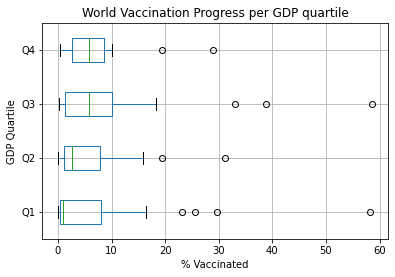

ANOVA: Fail to reject Null Hypothesis 



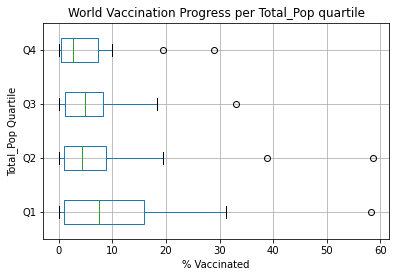

ANOVA: Fail to reject Null Hypothesis 



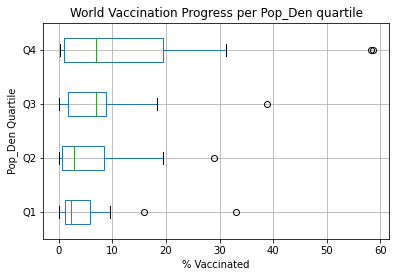

ANOVA: Pop_Den Reject Null Hypothesis 



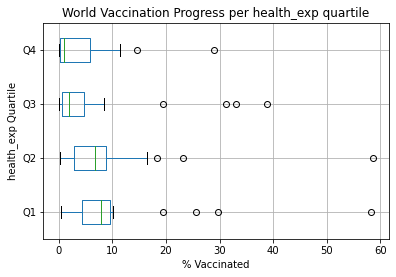

ANOVA: Fail to reject Null Hypothesis 



In [5]:
# Group data by bins and look at mean vaccination
for i in indicators:
    #Cut data into quartiles based on indicators
    iso_cleaned_df[f'{i}_Bins'] = pd.qcut(iso_cleaned_df[i],4,labels=quartiles)
    
    #Boxplot with data grouped by indicator bins
    iso_cleaned_df.boxplot(column='people_fully_vaccinated_per_hundred',
                           by=f'{i}_Bins',
                           vert=False
                          )
    #Plot formatting
    plt.suptitle('')
    plt.title(f'World Vaccination Progress per {i} quartile')
    plt.ylabel(f'{i} Quartile')
    plt.xlabel(f'% Vaccinated')
    
    #Save figure
    plt.savefig(f'./Resources/Output/Box/{i}.vaccMean.png')
    plt.show()

   
    #Statistical Testing
    q1 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q1']
    q2 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q2']
    q3 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q3']
    q4 = iso_cleaned_df[iso_cleaned_df[f'{i}_Bins']=='Q4']
   
    statistic, pvalue = f_oneway(q1['people_fully_vaccinated_per_hundred'],
             q2['people_fully_vaccinated_per_hundred'],
             q3['people_fully_vaccinated_per_hundred'],
             q4['people_fully_vaccinated_per_hundred']
            )
    alpha = 0.05
    if pvalue <= alpha:
        print(f'ANOVA: {i} Reject Null Hypothesis \n')
    else:
        print('ANOVA: Fail to reject Null Hypothesis \n')

Since we are able to reject the null hypothesis in the case of population density, we can say at least one mean vaccination percentage per density quartile is different.

In [6]:
iso_cleaned_df

,iso_code,Country,GDP,Total_Pop,Pop_Den,health_exp,Lat_avg,Lng_avg,total_vaccinations,people_fully_vaccinated_per_hundred,GDP_Bins,Total_Pop_Bins,Pop_Den_Bins,health_exp_Bins
0,ALB,Albania,1.514702e+10,2866376.0,104.612263,44.657787,41.0000,20.0000,400064.0,0.02,Q1,Q1,Q3,Q3
1,AND,Andorra,3.218316e+09,77006.0,163.842553,32.065220,42.5000,1.6000,26414.0,6.06,Q1,Q1,Q3,Q2
2,ARE,United Arab Emirates,4.222150e+11,9630959.0,135.609110,48.421539,24.0000,54.0000,10336214.0,38.79,Q3,Q2,Q3,Q3
3,ARG,Argentina,5.176267e+11,44494502.0,16.258510,38.290127,-34.0000,-64.0000,7386650.0,1.95,Q4,Q4,Q1,Q3
4,AUT,Austria,4.550949e+11,8840521.0,107.131859,26.914829,47.3333,13.3333,2863389.0,8.73,Q4,Q2,Q3,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TUR,Turkey,7.783819e+11,82319724.0,106.960129,22.617729,39.0000,35.0000,21678461.0,9.84,Q4,Q4,Q3,Q1
96,URY,Uruguay,5.959689e+10,3449299.0,19.708028,27.016809,-33.0000,-56.0000,1695351.0,15.95,Q2,Q1,Q1,Q2
97,USA,United States,2.058016e+13,326687501.0,35.713622,49.587131,38.0000,-97.0000,232407669.0,28.93,Q4,Q4,Q2,Q4
98,ZAF,South Africa,3.682889e+11,57792520.0,47.640752,44.066910,-29.0000,24.0000,292623.0,0.49,Q3,Q4,Q2,Q3


### Linear Regression for total vaccination percentage

In [7]:
def random_color():
    rgbl=[1,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

In [8]:
indicators = ['GDP','Total_Pop','Pop_Den','health_exp']
quartiles = ['Q1','Q2','Q3','Q4']

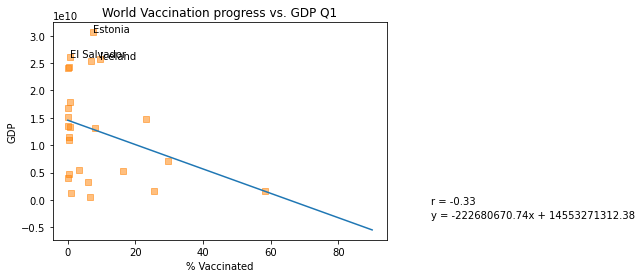

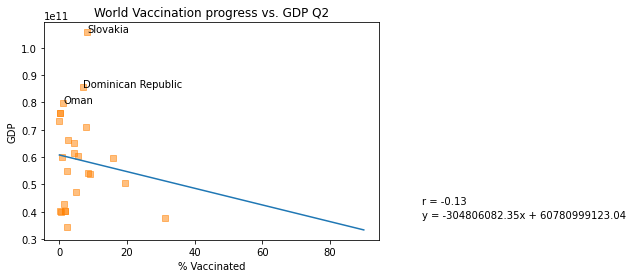

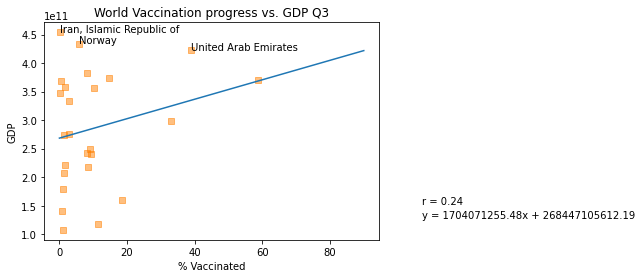

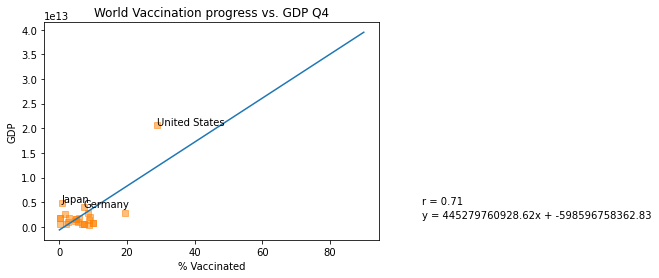

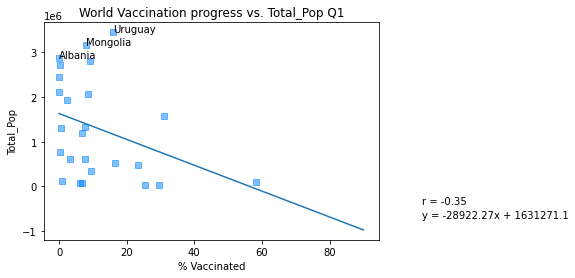

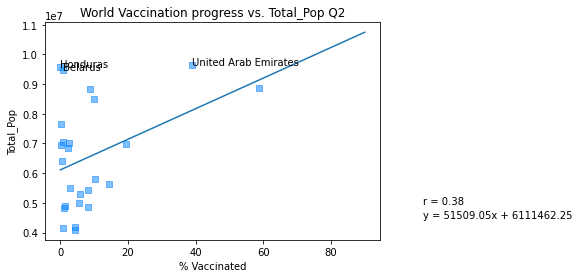

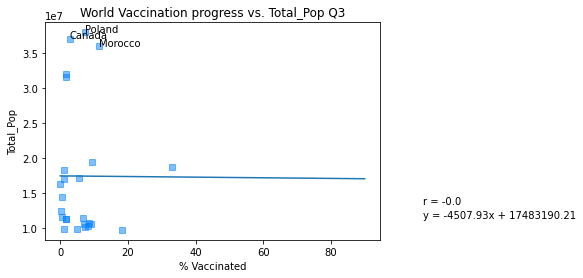

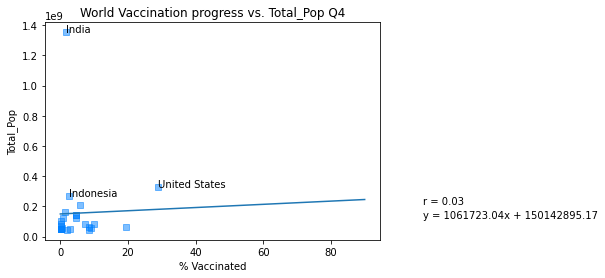

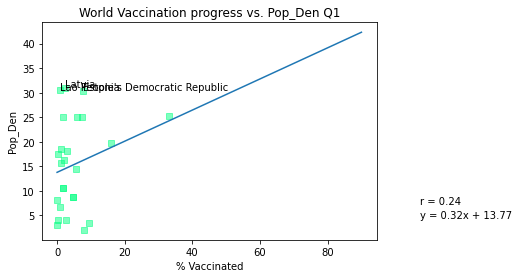

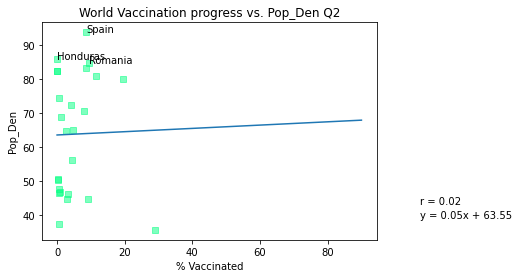

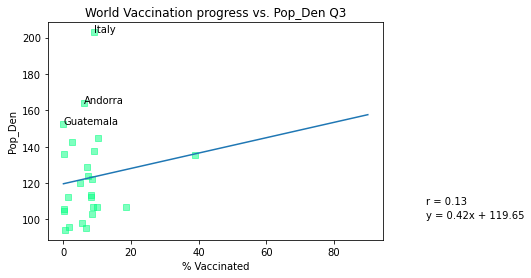

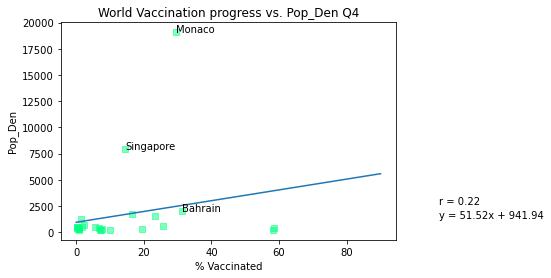

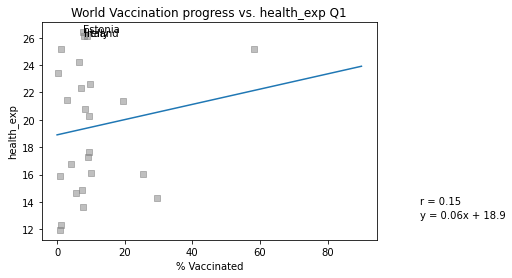

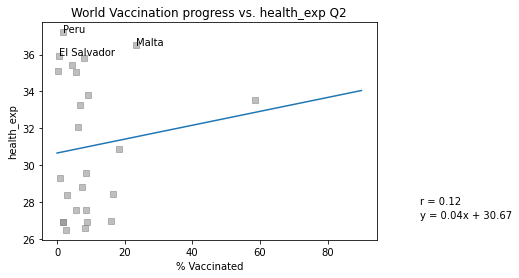

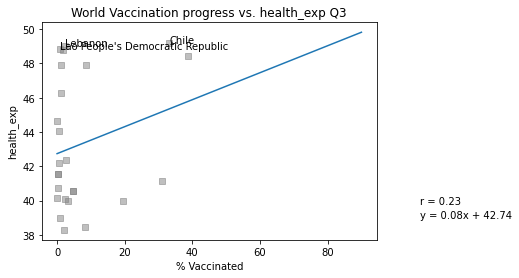

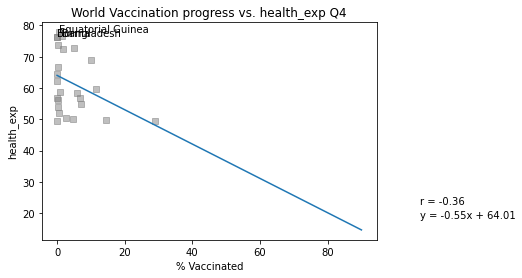

In [9]:
# Linear Regression for each data series compared to Vaccinations per 100 people
for j,metric in enumerate(indicators) :
    colorSeed = [(1,.5,0),(0,.5,1),(0,1,.5),(.5,.5,.5)]
    for quartile in quartiles : 
        dummy_df = iso_cleaned_df[iso_cleaned_df[f'{metric}_Bins']==quartile].reset_index()
        x = dummy_df['people_fully_vaccinated_per_hundred']
        y = dummy_df[metric]
        analysisDate = '05/03/2021'

        #lin reg line
        slope, intercept, rvalue, pvalue, stderr = linregress(x,y)
        z = range(0,100,10)
        w = slope * z + intercept

        #Scatter plot 
        fig, ax = plt.subplots()
        scatter = ax.scatter(x, y, s=30, color=colorSeed[j], alpha=.5,marker='s' )

        #line of best fit
        plt.plot(z,w)

        #rvalue and equation information
        plt.text(1,.25,f'r = {round(rvalue,2)}', transform=plt.gcf().transFigure)
        plt.text(1,.20,f'y = {round(slope,2)}x + {round(intercept,2)}', transform=plt.gcf().transFigure)

        #Formatting
        plt.title('World Vaccination progress vs. '+y.name + ' '+ quartile)
        plt.xlabel('% Vaccinated')
        plt.ylabel(y.name)
        
        
        #Labels for each point
        sorted_df = dummy_df.sort_values(by=metric,ascending=False).head(3).reset_index()
        for i, txt in enumerate(sorted_df['Country']):
            a = sorted_df['people_fully_vaccinated_per_hundred'][i]
            b = sorted_df[metric][i]
            ax.annotate(txt, (a, b))


        #Save figure and display
        plt.savefig(f'./Resources/Output/Line/{y.name}.Vaccine%.{quartile}Line.png')
        plt.show()

### Best and Worst performing countries in vaccine deployment in data set

In [10]:
x = iso_cleaned_df[['Country','people_fully_vaccinated_per_hundred']]
y = iso_cleaned_df[['Country','total_vaccinations']]

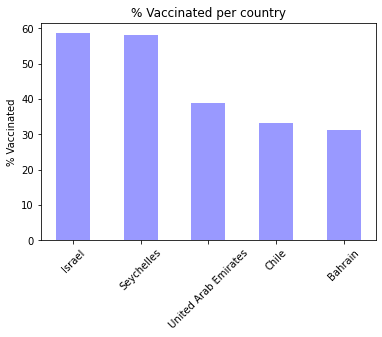

In [11]:
topVacc = x.sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(5)
plt.bar(topVacc['Country'],topVacc['people_fully_vaccinated_per_hundred'],width=.5,color='b',alpha=.4)
plt.title('% Vaccinated per country')
plt.ylabel('% Vaccinated')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/top5%.png')
plt.show()

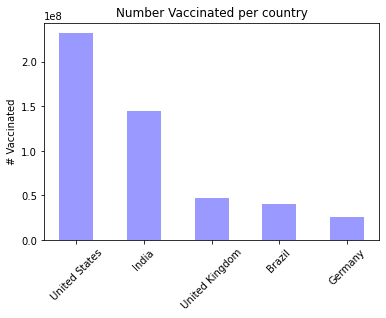

In [12]:
topTotal = y.sort_values(by='total_vaccinations',ascending=False).head(5)
plt.bar(topTotal['Country'],topTotal['total_vaccinations'],width=.5,color='b',alpha=.4)
plt.title('Number Vaccinated per country')
plt.ylabel('# Vaccinated')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/top5#.png')
plt.show()

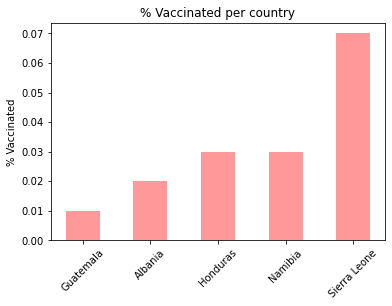

In [13]:
topVacc = x.sort_values(by='people_fully_vaccinated_per_hundred').head(5)
plt.bar(topVacc['Country'],topVacc['people_fully_vaccinated_per_hundred'],width=.5,color='r',alpha=.4)
plt.title('% Vaccinated per country')
plt.ylabel('% Vaccinated')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/bot5%.png')
plt.show()

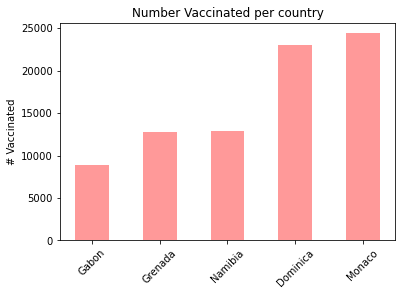

In [14]:
topTotal = y.sort_values(by='total_vaccinations').head(5)
plt.bar(topTotal['Country'],topTotal['total_vaccinations'],width=.5,color='r',alpha=.4)
plt.title('Number Vaccinated per country')
plt.ylabel('# Vaccinated')
plt.xticks(rotation = 45)
plt.savefig('./Resources/Output/bestandworst/bot5#.png')
plt.show()

### Gmaps heatmap